# Imported all the necessary data, and loaded in the data set

In [509]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

path = '../../../data/kc_housing_data.csv'
all_data = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/bsc-phase-two-project/main/data/kc_house_data.csv')

In [663]:
all_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


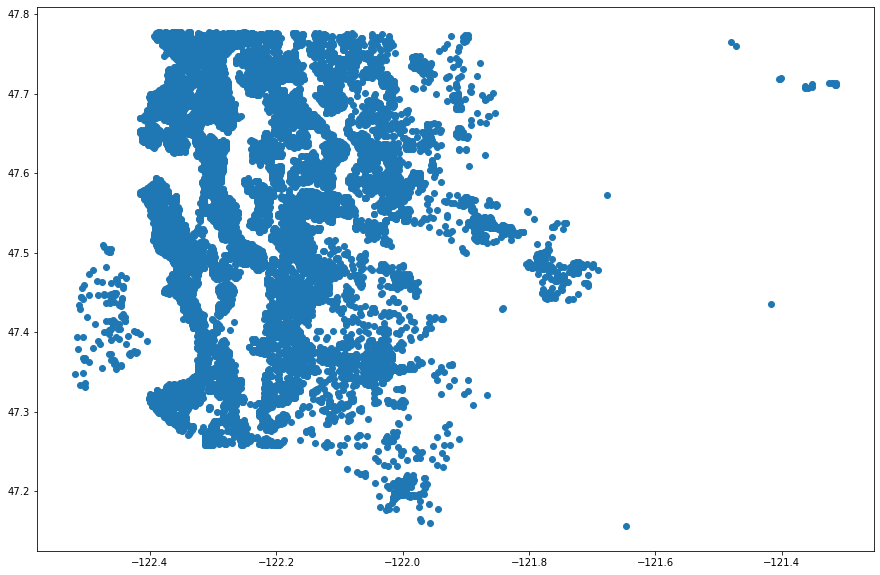

In [671]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x='long', y='lat', data=all_data)

In [123]:
all_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Creating new variables

### Added Age and Cleaned Columns

In [652]:
df = all_data.drop(['view', 'zipcode', 'lat', 'long', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1)

In [653]:
yrs = [int(x[-4:]) for x in df['date']]
df['date'] = yrs

In [654]:
for x in range(len(df)):
    if df['yr_renovated'][x] == True:
        if df['yr_renovated'][x] > 0:
            df['yr_built'][x] = df['yr_renovated'][x]

In [655]:
df['renovated'] = [int(x) for x in (df['yr_renovated'] > 0)]

In [656]:
df['yr_renovated/built'] = df['yr_built']

In [657]:
df['age'] = df['date'] - df['yr_renovated/built']

In [659]:
df.drop(['yr_renovated','yr_built', 'date'], axis=1, inplace=True)

### One-Hot Encoded Basement

In [661]:
df['sqft_basement'] = df['sqft_basement'].fillna(0)
df['sqft_basement'] = df['sqft_basement'].str.replace('?', '0')
df['sqft_basement'] = df['sqft_basement'].astype(float)
df['has_basement'] = [int(x) for x in df['sqft_basement'] > 0]
df = df.drop('sqft_basement', axis=1)

# Making first model

In [385]:
X = sm.add_constant(df[['sqft_living', 'floors', 'grade', 'age']])
y = df['price']
model_1 = sm.OLS(Y, X)
results = model_1.fit()

In [386]:
X = df[['sqft_living', 'floors', 'grade', 'age']]

In [387]:
residuals = results.resid

In [388]:
preds = results.predict()

# Making a Function to check assumptions

In [575]:
def check_model(model, X, y):
    results = model.fit()
    residuals = results.resid
    preds = results.predict()
        
    display(rainbow(results), vif(X), heteroskd(preds, y), norm_resids(residuals))
           

'P-value of linearity: 2.467415663044872e-09'

,VIF,feature
0,11.491152,sqft_living
1,12.178606,floors
2,31.400047,grade
3,3.102830,age


None

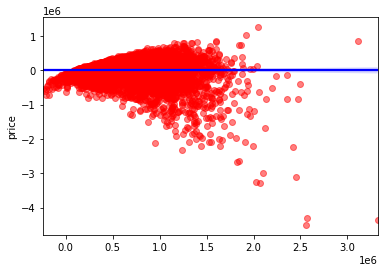

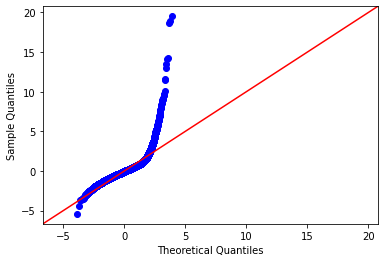

In [576]:
check_model(model_1, X, y)

### Function for Varience Inflection Factor

In [411]:
def vif(X_data):
    rows = X_data.values
    vif_df = pd.DataFrame()
    vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(4)]
    vif_df["feature"] = ['sqft_living', 'floors', 'grade', 'age']
    return vif_df

In [358]:
vif(X)

,VIF,feature
0,11.491152,sqft_living
1,12.178606,floors
2,31.400047,grade
3,3.102830,age


### Function of Normality of Residuals

In [573]:
def norm_resids(residuals):
    figureqq = sm.graphics.qqplot(residuals, dist=stats.norm, fit=True, line='45');

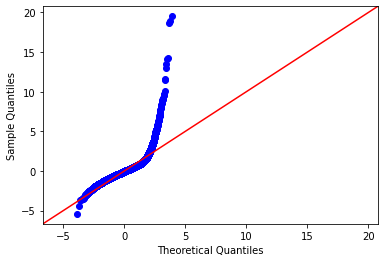

In [574]:
norm_resids(residuals)

### Function of Heteroskedascicity

In [563]:
def heteroskd (preds, Y):
    resids = preds - Y
    figure = sns.regplot(preds, resids, color='red', 
                       line_kws={'color':'blue'}, 
                       scatter_kws={'alpha':.5});
    return figure

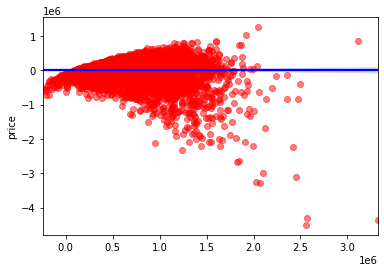

In [564]:
heteroskd(preds, Y);

### Function for Linear Rainbow Test

In [449]:
def rainbow(results):
    fstat, pvalue = sm.stats.diagnostic.linear_rainbow(results)
    return f'P-value of linearity: {pvalue}'

In [450]:
rainbow(results)

'P-value of linearity: 2.467415663044872e-09'

### Function for idenfying outliers and number of outliers

In [578]:
def outliers(column):
    Q1 = df[column].quantile(.25)
    Q3 = df[column].quantile(.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    
    return lower_lim, upper_lim

In [608]:
outliers('sqft_lot')

19152.5

In [616]:
def outlier_count(column):
    high_o = (df[column] > outliers(column)[1]).sum()
    low_o = (df[column] < outliers(column)[0]).sum()
    return high_o, low_o

In [619]:
print(outlier_count('sqft_lot'))
print(outlier_count('sqft_living'))
print(outlier_count('bathrooms'))
print(outlier_count('bedrooms'))
print(outlier_count('floors'))

(2419, 0)
(571, 0)
(557, 4)
(334, 196)
(0, 0)


# Blah

In [ ]:
model = sm.MixedLM.from_formula("BPXSY1 ~ RIDAGEYR + RIAGENDRx + BMXBMI + C(RIDRETH1)",
           groups="group", data=da)
result = model.fit()
result.summary()